# Object Detection with YOLO

## Using Ultralytics

In [51]:
from ultralytics import YOLO

### Load a pretrained YOLO model (recommended for training)

In [52]:
model = YOLO("yolo11n.pt")

### Perform object detection on an image using the model

In [53]:
# from PIL import Image
# img = Image.open("/home/saeed/img.png")
results = model("img.png")


image 1/1 /home/saeed/img.png: 640x640 4 persons, 8 cars, 2 traffic lights, 112.4ms
Speed: 13.0ms preprocess, 112.4ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)


In [55]:
result1 = results[0]

In [56]:
print(result1.boxes.cls)

tensor([2., 0., 9., 2., 9., 0., 2., 0., 2., 2., 2., 0., 2., 2.], device='cuda:0')


In [57]:
print(result1.boxes.conf)

tensor([0.8534, 0.8260, 0.7790, 0.7567, 0.7456, 0.5397, 0.5367, 0.5117, 0.5096, 0.4917, 0.4846, 0.4155, 0.3897, 0.2619], device='cuda:0')


In [58]:
print(result1.boxes.xyxy)

tensor([[318.0560, 157.3013, 413.1741, 240.8428],
        [ 62.5463, 139.2057,  99.0420, 258.7773],
        [172.7429,  51.8092, 196.4328, 102.2453],
        [271.5280, 183.4301, 294.2990, 199.9390],
        [138.3076,  52.8913, 160.9026,  88.1370],
        [426.0867, 167.0221, 440.5210, 200.7570],
        [ 92.7246, 187.0260, 118.8708, 205.0625],
        [ 31.5651, 176.6467,  43.5639, 207.5876],
        [314.0969, 174.7029, 325.8281, 196.4775],
        [123.5957, 184.3218, 143.6483, 200.4582],
        [ 51.1105, 187.5389,  66.6586, 203.5877],
        [  7.5279, 171.7466,  22.3281, 209.7182],
        [305.9152, 182.7790, 314.0060, 192.3674],
        [ 92.9687, 187.0750, 108.5286, 205.7023]], device='cuda:0')


## Using HF Transformers

In [59]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from PIL import Image
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny", use_fast=True)
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

In [61]:
image = Image.open('img.jpg')

In [62]:
inputs = processor(images=image, return_tensors="pt")

In [33]:
with torch.no_grad():
    outputs = model(**inputs)

In [63]:
target_sizes = torch.tensor([image.size[::-1]], device=device)  # (H, W)
results2 = processor.post_process_object_detection(
    outputs=outputs, threshold=0.5, target_sizes=target_sizes
)

In [64]:
results2[0]

{'scores': tensor([0.6781, 0.6741, 0.6051, 0.6021, 0.5759, 0.5755, 0.5375, 0.5122, 0.5056]),
 'labels': tensor([91, 91,  8, 91, 91, 91, 91, 91, 91]),
 'boxes': tensor([[134.0754,  53.5347, 157.4558,  93.0646],
         [316.6178, 153.2402, 414.6814, 238.3491],
         [316.6178, 153.2402, 414.6814, 238.3491],
         [ 64.3432, 140.5640,  97.4862, 228.4455],
         [ 54.3295,  68.6764, 399.7014, 237.3123],
         [204.1792, 179.2746, 246.1664, 216.2867],
         [151.9265,  51.5111, 187.6804,  91.0614],
         [301.0330, 379.8960, 352.5000, 426.6423],
         [320.6803, 153.9213, 413.4036, 237.4293]])}

In [65]:
result2 = results2[0]

In [66]:
# result has 'scores' (N,), 'labels' (N,), 'boxes' (N, 4) in xyxy image coords
scores = result2["scores"].detach().cpu()
labels = result2["labels"].detach().cpu()
boxes  = result2["boxes"].detach().cpu()  # xyxy
id2label = model.config.id2label

## Visualization

In [121]:
import matplotlib.pyplot as plt

In [122]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def standardize_ultralytics(res):
    """Convert Ultralytics YOLO result to dict of numpy arrays + names mapping."""
    return {
        "boxes": to_numpy(res.boxes.xyxy),
        "scores": to_numpy(res.boxes.conf),
        "labels": to_numpy(res.boxes.cls).astype(int),
        "names": res.names,
    }

def standardize_yolos(res, model):
    """Convert HuggingFace YOLOS dict to dict of numpy arrays + id2label mapping."""
    return {
        "boxes": to_numpy(res["boxes"]),
        "scores": to_numpy(res["scores"]),
        "labels": to_numpy(res["labels"]).astype(int),
        "names": model.config.id2label,
    }

In [128]:
def draw_boxes(ax, img, boxes, labels, scores, label_map, color, title=None, score_thresh=0.0, lw=2):
    ax.imshow(img)
    ax.axis("off")
    shown = 0
    for (x1, y1, x2, y2), cid, s in zip(boxes, labels, scores):
        if s < score_thresh:
            continue
        name = label_map.get(int(cid), str(cid))
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, linewidth=lw, edgecolor=color)
        ax.add_patch(rect)
        ax.text(
            x1,
            max(0, y1 - 5),
            f"{name} ({s:.2f})",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
            color="black",
        )
        shown += 1
    if title:
        ax.set_title(f"{title}\n(shown ≥{score_thresh:.2f}: {shown})", fontsize=11)

In [109]:
def iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    ua = max(0.0, (ax2 - ax1)) * max(0.0, (ay2 - ay1))
    ub = max(0.0, (bx2 - bx1)) * max(0.0, (by2 - by1))
    return inter / (ua + ub - inter + 1e-9)

In [110]:
def greedy_match(boxes1, boxes2, thr=0.5):
    matches, u1, u2 = [], set(range(len(boxes1))), set(range(len(boxes2)))
    for i in range(len(boxes1)):
        best_j, best = -1, 0.0
        for j in list(u2):
            val = iou(boxes1[i], boxes2[j])
            if val > best:
                best, best_j = val, j
        if best_j >= 0 and best >= thr:
            matches.append((i, best_j, best))
            u1.discard(i)
            u2.discard(best_j)
    return matches, sorted(u1), sorted(u2)

In [123]:
# ==== STANDARDIZE ====
r1 = standardize_ultralytics(result1)
r2 = standardize_yolos(result2, model)

In [114]:
# Optional filtering
SCORE_THRESH = 0.5
mask1 = r1["scores"] >= SCORE_THRESH
mask2 = r2["scores"] >= SCORE_THRESH

In [126]:
b1, l1, s1 = r1["boxes"][mask1], r1["labels"][mask1], r1["scores"][mask1]
b2, l2, s2 = r2["boxes"][mask2], r2["labels"][mask2], r2["scores"][mask2]

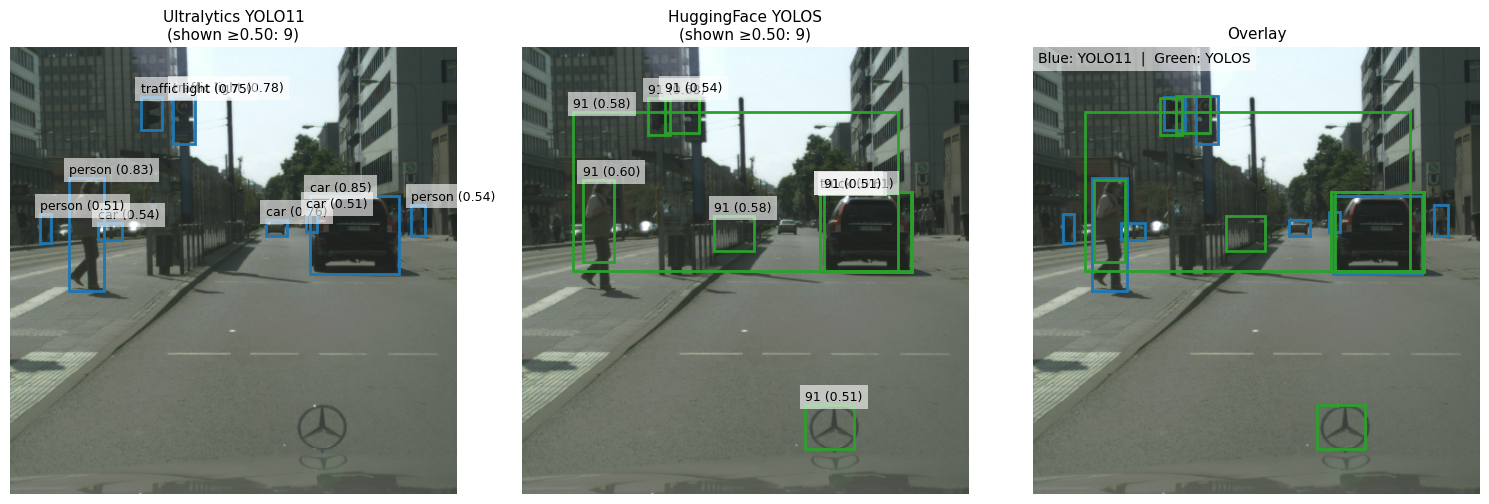

In [129]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
draw_boxes(ax1, img, b1, l1, s1, label_map=r1["names"], color="tab:blue",
           title="Ultralytics YOLO11", score_thresh=SCORE_THRESH)
ax2 = plt.subplot(1, 3, 2)
draw_boxes(ax2, img, b2, l2, s2, label_map=r2["names"], color="tab:green",
           title="HuggingFace YOLOS", score_thresh=SCORE_THRESH)
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(img)
ax3.axis("off")
ax3.set_title("Overlay", fontsize=11)
for (x1, y1, x2, y2) in b1:
    ax3.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2, edgecolor="tab:blue"))
for (x1, y1, x2, y2) in b2:
    ax3.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2, edgecolor="tab:green"))
ax3.text(5, 15, "Blue: YOLO11  |  Green: YOLOS", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
plt.tight_layout()
plt.show()

In [130]:
# ---------- Quick agreement check ----------
matches, u1, u2 = greedy_match(b1, b2, thr=0.5)
print(f"Greedy IoU≥0.50 matches: {len(matches)}")
for i, j, m in matches:
    print(f"  YOLO11 {i} ↔ YOLOS {j} | IoU={m:.2f} | ids {l1[i]}/{l2[j]} | scores {s1[i]:.2f}/{s2[j]:.2f}")
print("Ultralytics-only (no match):", u1)
print("YOLOS-only (no match):", u2)

Greedy IoU≥0.50 matches: 3
  YOLO11 0 ↔ YOLOS 1 | IoU=0.90 | ids 2/91 | scores 0.85/0.67
  YOLO11 1 ↔ YOLOS 3 | IoU=0.67 | ids 0/91 | scores 0.83/0.60
  YOLO11 4 ↔ YOLOS 0 | IoU=0.63 | ids 9/91 | scores 0.75/0.68
Ultralytics-only (no match): [2, 3, 5, 6, 7, 8]
YOLOS-only (no match): [2, 4, 5, 6, 7, 8]
